# Detecting Anomalies

The purpose of this notebook is to detect abnormalities within a scalar.

In [340]:
import re
import sys
import random

# Setup the "PYTHONPATH"
sys.path.insert(0, '../')

In [378]:
import math

def get_running_mean_and_standard_deviation(steps, values, beta=0.9, sigma=8):
    """ Compute exponentially weighted running mean and standard deviation.
    
    Args:
        steps (list of float): Step at which each value occured.
        values (list of float): Values at each step.
        beta (float): Beta used to weight the exponential mean and standard deviation.
        sigma (float): Number of standard deviations before ignoring an abnormality.
        
    Returns:
        means (list of float): Exponentially weighted running means for each step.
        standard_deviations (list of float): Exponentially weighted running standard deviation for each step.
    """
    assert len(values) == len(steps)
    
    means, standard_deviations = [], []
    average, variance = 0.0, 0.0
    last_abnormality = 0
    for i, (step, value) in enumerate(zip(steps, values)):
        # Detected abnormality
        # NOTE: ``i < 1`` then ``variance == 0.0``
        # NOTE: Above a sample size 10, we do not need to consider sample variance bias correction
        if i > 10 and abs(value - average_bias_corrected) > standard_deviations[-1] * sigma:
            if i > last_abnormality + 100:
                print('Detected abnormality (%f > %f ± %f), at index %d or step %d (step ignored)' %
                      (value, average_bias_corrected, standard_deviations[-1] * sigma, i, step))
            last_abnormality = i

            # Instead of registering the abnormality, we use the last computed values
            means.append(average_bias_corrected)
            standard_deviations.append(math.sqrt(variance_bias_corrected))
            continue
                
                
        average = beta * average + (1 - beta) * value
        average_bias_corrected = average / (1 - beta**(i + 1))
        
        variance = beta * variance + (1 - beta) * (value - average_bias_corrected) ** 2
        variance_bias_corrected = variance / (1 - beta**(i + 1))
        
        means.append(average_bias_corrected)
        standard_deviations.append(math.sqrt(variance_bias_corrected))
    return means, standard_deviations

def plot_abnormality(steps, values, means, standard_deviations, sigma=8):
    """ Compute exponentially weighted running mean and standard deviation.
    
    Args:
        step (list of float): Step at which each value occured.
        value (list of float): Values at each step.
        means (list of float): Exponentially weighted running means for each step.
        standard_deviations (list of float): Exponentially weighted running standard deviation for each step.
        sigma (float): Number of standard deviations before ignoring an abnormality.        
    """
    pyplot.figure(figsize=(20, 10))
    pyplot.style.use('ggplot')
    kwargs = {
        'marker': '.',
        'linestyle': 'solid'
    }
    pyplot.plot(steps, values, label='Value', **kwargs)
    pyplot.plot(steps, means, label='Mean', **kwargs)
    
    upper_bound = [value + sigma * sd for value, sd in zip(means, standard_deviations)]
    lower_bound = [value - sigma * sd for value, sd in zip(means, standard_deviations)]

    pyplot.plot(steps, upper_bound, label='Upper Bound', **kwargs)
    pyplot.plot(steps, lower_bound, label='Lower Bound', **kwargs)
    
    pyplot.legend()
    pyplot.ylabel('Value')
    pyplot.xlabel('Step')

In [374]:
def load_tensorboard_data(path):
    data = [row for row in open(path, 'r')]
    print('Header:', data[0].strip())
    data = [tuple([float(val) for val in row.strip().split(',')]) for row in data[1:]]
    print('Sample:', data[:5])
    _, step, value = zip(*data)
    return step, value

print('Loading parameter norm data...')
parameter_norm_step, parameter_norm_value = load_tensorboard_data(
    '/tmp/csv_output/data_tensorboard_train___parameter_norm_step.csv')
print('\nLoading coarse step data...')
coarse_loss_step, coarse_loss_value = load_tensorboard_data(
    '/tmp/csv_output/data_tensorboard_train___coarse_loss_step.csv')

Loading parameter norm data...
Header: wall_time,step,value
Sample: [(1532494124.6992335, 130.0, 1.247214674949646), (1532494133.8360758, 133.0, 1.0535839796066284), (1532494134.1601946, 137.0, 1.5540196895599365), (1532494134.4904237, 140.0, 1.3031283617019653), (1532494134.8135393, 143.0, 1.2728163003921509)]

Loading coarse step data...
Header: wall_time,step,value
Sample: [(1532494124.6998193, 130.0, 5.541497230529785), (1532494133.836773, 133.0, 5.344502925872803), (1532494134.160786, 137.0, 5.036365509033203), (1532494134.490883, 140.0, 4.824010372161865), (1532494134.8140569, 143.0, 4.7027130126953125)]


In [375]:
%matplotlib inline

from matplotlib import pyplot

sigma = 6

In [376]:
parameter_norm_mean, parameter_norm_standard_deviation = get_running_mean_and_standard_deviation(
    parameter_norm_step, parameter_norm_value, sigma=8, beta=0.999)

Detected abnormality (12.815134 > 1.979099 ± 10.626227), at index 747 or step 2539 (step ignored)
Detected abnormality (18.418140 > 2.393985 ± 13.757632), at index 906 or step 3051 (step ignored)
Detected abnormality (30.592886 > 3.745455 ± 24.759076), at index 1318 or step 4376 (step ignored)
Detected abnormality (38.274529 > 4.550713 ± 33.355990), at index 1741 or step 5739 (step ignored)
Detected abnormality (42.193306 > 4.884191 ± 35.928216), at index 1856 or step 6109 (step ignored)
Detected abnormality (84.536537 > 10.107314 ± 69.966877), at index 3049 or step 9953 (step ignored)
Detected abnormality (2540.206055 > 41.965634 ± 236.510203), at index 247248 or step 795947 (step ignored)


In [405]:
coarse_loss_mean, coarse_loss_standard_deviation = get_running_mean_and_standard_deviation(
    coarse_loss_step, coarse_loss_value, sigma=6, beta=0.99)

Detected abnormality (1.816936 > 1.179803 ± 0.630913), at index 1522 or step 5033 (step ignored)
Detected abnormality (1.472018 > 0.684699 ± 0.458473), at index 28349 or step 91590 (step ignored)
Detected abnormality (1.064265 > 0.633462 ± 0.416581), at index 63063 or step 203652 (step ignored)
Detected abnormality (7.356693 > 0.582577 ± 0.419809), at index 247248 or step 795947 (step ignored)


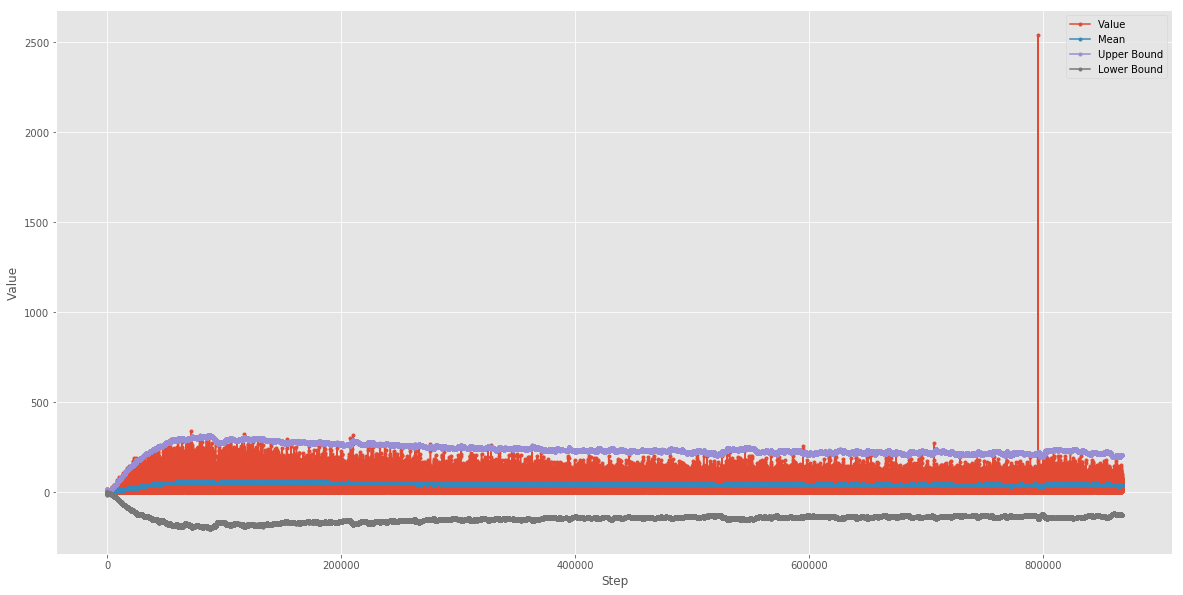

In [400]:
start = 0
end = len(parameter_norm_step)
plot_abnormality(parameter_norm_step[start:end],
                 parameter_norm_value[start:end],
                 parameter_norm_mean[start:end],
                 parameter_norm_standard_deviation[start:end],
                 sigma=sigma)

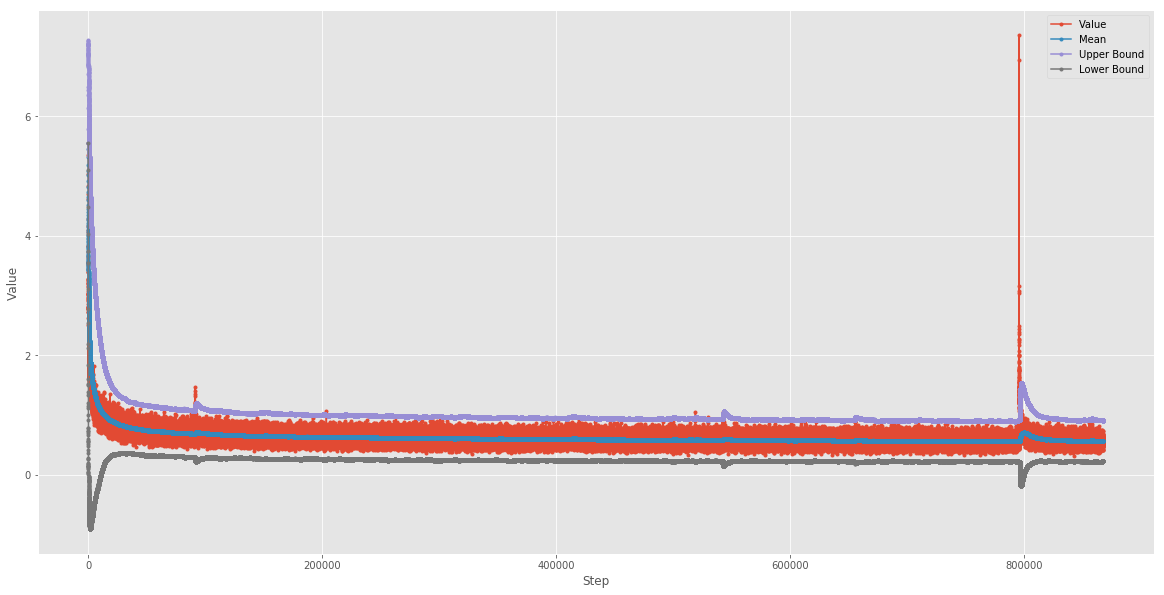

In [404]:
plot_abnormality(coarse_loss_step[start:end],
                 coarse_loss_value[start:end],
                 coarse_loss_mean[start:end],
                 coarse_loss_standard_deviation[start:end],
                 sigma=5)